# Statistical analysis of topological variables

##### Import Modules

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd

##### Read the dataframes holding the topological values of each network and convert each dataframe to long format
This makes it easier to perform statistical analysis and plotting by having one column for treatment and one for value.

In [15]:
# Load the datasets with titles for better tracking
files = {
    "Neighborhood Connectivity": "outputs/neighborhood_connectivity_all_treat.csv",
    "Closeness Centrality": "outputs/closeness_centrality_all_treat.csv",
    "Clustering Coefficient": "outputs/clustering_coefficient_all_treat.csv"
}

dfs = {name: pd.read_csv(path, sep= '\t') for name, path in files.items()}

# Change to long format to better analyze the information
dfs_long = {
    name: df.melt(var_name= "treatment", value_name= "value").dropna()
    for name, df in dfs.items()
}

# See head of each dataframe
for name, df in dfs_long.items():
    print(f"\n{name}")
    print(df.head())


Neighborhood Connectivity
  treatment  value
0        AN    2.0
1        AN    1.0
2        AN    1.0
3        AN    3.0
4        AN    2.0

Closeness Centrality
  treatment  value
0        AN    0.0
1        AN    0.0
2        AN    1.0
3        AN    0.6
4        AN    0.0

Clustering Coefficient
  treatment  value
0        AN    0.0
1        AN    0.0
2        AN    0.0
3        AN    0.0
4        AN    0.0


##### Define a function to perform statistical tests
- Checks normality and variance. 
- Uses ANOVA with Tukey posthoc if assumptions (ones above) are met.
- Uses Kruskal–Wallis with Dunn posthoc otherwise.

In [ ]:
def run_stats(df, feature_name):

    # Get the treatment groups
    treatments = df["treatment"].unique()
    groups = []
    for t in treatments:
        group_values = df.loc[df["treatment"] == t, "value"].values
        groups.append(group_values)

    # Check assumptions to define best test later
    normality_results = []
    for g in groups:
        if len(g) > 3:  # Shapiro needs a minimum of 3 values
            stat, pval = stats.shapiro(g)
            normality_results.append(pval > 0.05) # Store values > 0.05
        else:
            # Too small for a real test, assume normality of data
            normality_results.append(True)

    # Overall normality = True only if all groups are normal
    normality = all(normality_results)

    # Levene test for equal variances of groups
    lev_stat, lev_pval = stats.levene(*groups)
    equal_var = lev_pval > 0.05

    # Pick the main test of the groups in general and taking into account the assumptions
    if normality and equal_var: # if both assumptions are met
        # Parametric: one-way ANOVA
        f_stat, p_val = stats.f_oneway(*groups)
        test_used = "ANOVA"

        # Posthoc: Tukey test to see which groups differ
        posthoc = pairwise_tukeyhsd(
            endog= df["value"],
            groups= df["treatment"],
            alpha= 0.05
        )
        posthoc_df = pd.DataFrame(
            posthoc.summary().data[1:],  # Skip header row
            columns= posthoc.summary().data[0]
        )

    else: # if any assumption is not met
        # Non-parametric: Kruskal-Wallis to compare medians
        f_stat, p_val = stats.kruskal(*groups)
        test_used = "Kruskal–Wallis"

        # Posthoc: Dunn’s test to see which groups differ
        posthoc_df = sp.posthoc_dunn(
            df,
            val_col= "value",
            group_col= "treatment",
            p_adjust= "bonferroni"
        )

    # Prepare a summary to show the results
    summary = {
        "feature": feature_name,
        "test": test_used,
        "statistic": f_stat,
        "p_value": p_val
    }

    return summary, posthoc_df


##### Run the statistical tests for each feature and collect the results.
Results are stored in a summary dataframe and posthoc results are kept for later inspection

In [27]:
summary = []
posthoc_results = {}

for feature_name, df in dfs_long.items():
    res, posthoc = run_stats(df, feature_name)
    summary.append(res)
    posthoc_results[feature_name] = posthoc

summary_df = pd.DataFrame(summary)
display(summary_df)

# Display posthoc results for each feature
for feature_name, posthoc in posthoc_results.items():
    print(f"\nPosthoc results for {feature_name}:")
    display(posthoc)


,feature,test,statistic,p_value
0,Neighborhood Connectivity,Kruskal–Wallis,1.300022,0.522040
1,Closeness Centrality,Kruskal–Wallis,15.735507,0.000383
2,Clustering Coefficient,Kruskal–Wallis,6.551141,0.037795



Posthoc results for Neighborhood Connectivity:


,AN,BP,MP
AN,1.00000,1.0,0.77112
BP,1.00000,1.0,1.00000
MP,0.77112,1.0,1.00000



Posthoc results for Closeness Centrality:


,AN,BP,MP
AN,1.000000,0.000328,0.027786
BP,0.000328,1.000000,0.567313
MP,0.027786,0.567313,1.000000



Posthoc results for Clustering Coefficient:


,AN,BP,MP
AN,1.00000,0.040320,1.000000
BP,0.04032,1.000000,0.176914
MP,1.00000,0.176914,1.000000


- Neighborhood Connectivity
All p-values > 0.05. There are no statistically significant differences in Neighborhood Connectivity between any pair of treatments (AN, BP, MP).

- Closeness Centrality
AN is significantly different from both BP and MP in Closeness Centrality. BP and MP are not significantly different from each other.

- Clustering Coefficient
AN is significantly different from BP in Clustering Coefficient.
AN and MP, BP and MP are not significantly different from each other.

##### Visualize the distribution of each feature by treatment using boxplots and stripplots.
Display the test results for pairwise comparisons

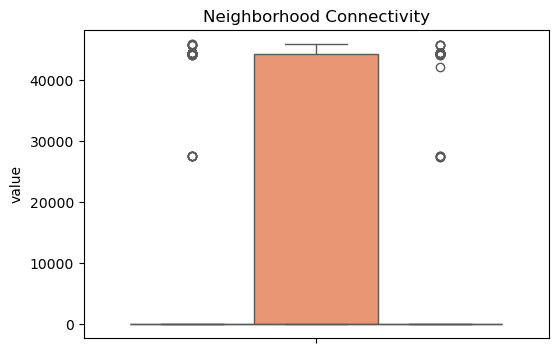

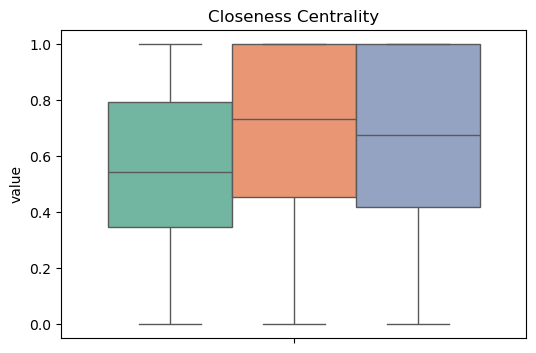

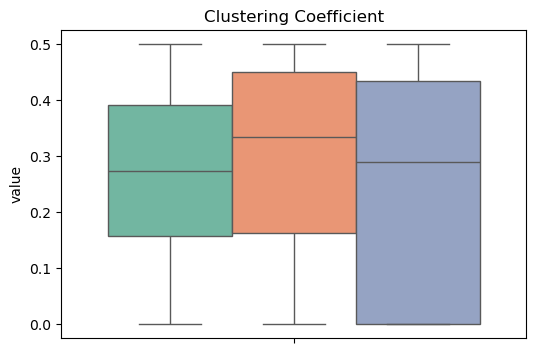

In [28]:
for feature_name, df in dfs_long.items():
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, hue="treatment", y="value", palette="Set2", legend= False)
    plt.title(f"{feature_name}")
    plt.show()
